# TODO

- checker avec Dorian et Julien la meilleure periode pour definir la pluie des recoltes
- choisir la date de debut des vendanges, selon TL plus probablement que selon Latour

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 5)

pheno = pd.read_excel('data/generated_pheno.xlsx', index_col=0)

pheno['Mi vendanges'] = (pheno['Begin vendanges'] + (pheno['End vendanges'] - pheno['Begin vendanges'])/2).dt.normalize()

display(pheno.head())

,Debourrement,Begin floraison,End floraison,Begin veraison,Half veraison,Begin vendanges,End vendanges,Debourrement - floraison interval,Floraison - veraison interval,Veraison - vendanges interval,Growing season duration,Mi vendanges
Année,,,,,,,,,,,,
1960,1960-03-18,1960-05-24,1960-05-30,1960-07-20,1960-08-02,1960-09-15,1960-10-06,67,64,44,181,1960-09-25
1961,1961-03-10,1961-05-16,1961-05-30,1961-07-23,1961-08-05,1961-09-17,1961-10-14,67,67,43,191,1961-09-30
1962,1962-04-14,1962-06-08,1962-06-17,1962-08-03,1962-08-16,1962-10-01,1962-10-22,55,60,46,170,1962-10-11
1963,1963-04-08,1963-06-13,1963-06-20,1963-08-13,1963-08-15,1963-10-01,1963-10-28,66,56,47,176,1963-10-14
1964,1964-04-06,1964-06-01,1964-06-14,1964-07-31,1964-08-13,1964-09-21,1964-10-20,56,60,39,168,1964-10-05


In [39]:

weather_st_em = pd.read_csv('data/weather/generated_weather_st_em.csv', parse_dates=['Date']).set_index('Date')
prices_st_em = pd.read_excel('data/prices/generated_average_prices_st_em.xlsx', index_col=0)

weather_medoc = pd.read_csv('data/weather/generated_weather_pauillac.csv', parse_dates=['Date']).set_index('Date')
prices_medoc = pd.read_excel('data/prices/generated_average_prices_medoc.xlsx', index_col=0)

weather_st_em = weather_st_em.drop(['Pl','Ps','Peff'], axis = 1)
weather_st_em['Frost'] = (weather_st_em['Tn'] < 0).astype(int) * (-weather_st_em['Tn'])
weather_st_em['DTR'] = weather_st_em['Tx'] - weather_st_em['Tn']

weather_medoc = weather_medoc.drop(['Pl','Ps','Peff'], axis = 1)
weather_medoc['Frost'] = (weather_medoc['Tn'] < 0).astype(int) * (-weather_medoc['Tn'])
weather_medoc['DTR'] = weather_medoc['Tx'] - weather_medoc['Tn']

#weather['CI'] = (weather['Tn'] < 15).astype(int)
#weather['Huglin'] = ((weather['Tx']-10) + (weather['Tm']-10))/2

#weather['Heavy Rain'] = (weather['P'] > 40).astype(int)
weather_st_em['Stress'] = 0.5*weather_st_em['ETP'] - weather_st_em['P']
weather_medoc['Stress'] = 0.5*weather_medoc['ETP'] - weather_medoc['P']

#weather['Very high'] = (weather['Tx'] > 36).astype(int) * (weather['Tx'] - 36)

ORIG_WEATHER_FEATURES = list(weather_medoc.columns)

#weather['Tm-25'] = (weather['Tx']<30).astype(int) * (weather['Tm']>20).astype(int)
weather_st_em['GDD10'] = ((weather_st_em['Tx']+weather_st_em['Tx'])/2 > 10).astype(int) * ((weather_st_em['Tx']+weather_st_em['Tx'])/2 - 10)
weather_medoc['GDD10'] = ((weather_medoc['Tx']+weather_medoc['Tx'])/2 > 10).astype(int) * ((weather_medoc['Tx']+weather_medoc['Tx'])/2 - 10)

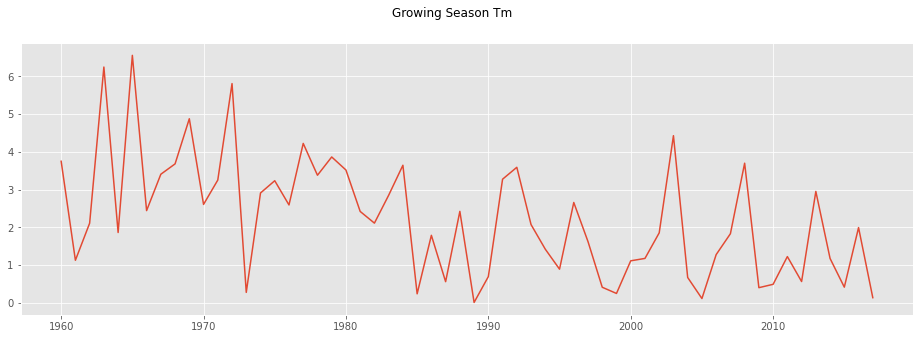

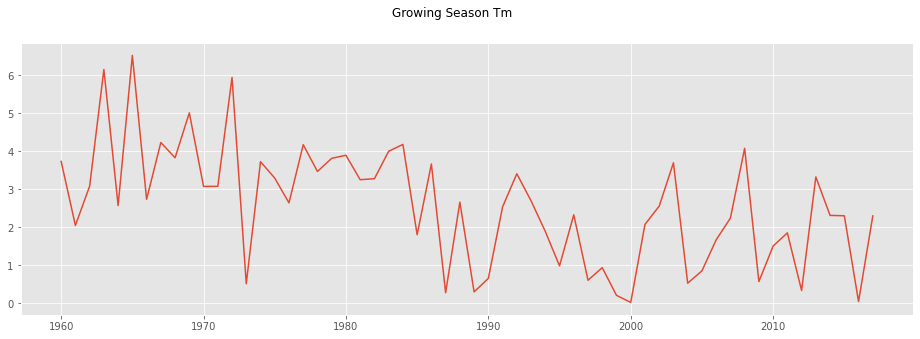

In [40]:
def create_df(weather):
    vintages = list(pheno.index)
    
    df = pd.DataFrame(index = vintages)
    
    events = ['debourrement', 'floraison', 'veraison', 'vendanges']
    
    intervals = {
        'debourrement - floraison' : ['Debourrement', 'Begin floraison'],
        'fleur' : ['Begin floraison', 'End floraison'],
        'floraison - veraison' : ['End floraison', 'Half veraison'],
        'veraison - vendanges': ['Half veraison', 'Begin vendanges'],
        'vendanges' : ['Begin vendanges', 'End vendanges']
    }
    
    # Adding all base features, declined on all intervals
    for feature in ORIG_WEATHER_FEATURES:
        subfeatures_list = [feature + ': '+ interval for interval in intervals.keys()]
            
        for subfeature in subfeatures_list:
            df[subfeature] = 0
    
        for interval in intervals.keys():
            feature_name = feature + ': '+ interval
            for vintage in vintages:
                date_begin, date_end = pheno.loc[vintage, intervals[interval][0]], pheno.loc[vintage, intervals[interval][1]]
                if feature in ['P', 'Hail', 'ETP', 'GDD10', 'Wind', 'Heavy Rain']:
                    df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].sum()  
                    
                #elif feature == 'GDD':
                #    date_debourrement = pheno.loc[vintage, 'debourrement']
                #    df.loc[vintage, feature_name] = weather.loc[date_debourrement:date_end, feature].sum()           
                else:
                    df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].mean()
                    
    df['Growing Season Tm'] = np.abs(df['Tx: veraison - vendanges'] - 26)
    #for vintage in vintages: # do not include first vintage
    #    date_begin = datetime.date(vintage, 4, 1) # Begin on April 1
    #    date_end = datetime.date(vintage , 9, 30) # End in September
    #    df.loc[vintage, 'Growing Season Tm'] += weather.loc[date_begin:date_end, 'Tm'].mean()
    plt.plot(df['Growing Season Tm'])
    plt.suptitle('Growing Season Tm')
    plt.show()
    
    
    #### Adding other features
    
    # Early frost: from October to November
    #df['Prev Fall Frost'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 9, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage - 1, 11, 1) # End in December
    #    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
    #           
    #    date_begin = datetime.date(vintage - 1, 11, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage - 1, 12, 1) # End in December
    #    df.loc[vintage, 'Prev Fall Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
        
    # Early frost: from October to November
    #df['Winter Frost'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 12, 1) # Begin on Dec 1, previous year
    #    date_end = pheno.loc[vintage, 'Debourrement'] - datetime.timedelta(days=15) # End in Feb
    #    df.loc[vintage, 'Winter Frost'] += weather.loc[date_begin:date_end, 'Frost'].sum()
               
    # Winter Tm
    #df['Winter Tn'] = 0
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 12, 15) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage , 3, 1) # End mid March
    #    df.loc[vintage, 'Winter Tn'] += weather.loc[date_begin:date_end, 'Tn'].mean()
    
    df['Winter Rain'] = 0
    for vintage in vintages[1:]: # do not include first vintage
        date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
        date_end = datetime.date(vintage , 3, 1) # End mid March
        df.loc[vintage, 'Winter Rain'] += weather.loc[date_begin:date_end, 'P'].mean()
    
    #df['Debourrement date'] = pheno['debourrement'].dt.dayofyear
    #df['Floraison date'] = pheno['floraison'].dt.dayofyear
    #df['Veraison date'] = pheno['veraison'].dt.dayofyear
    #df['Harvest date'] = pheno['vendanges'].dt.dayofyear

    #df['Dormancy'] = 0
    #weather['CD'] = (weather['Tm'] <= 7.2).astype(int)
    #for vintage in vintages[1:]: # do not include first vintage
    #    date_begin = datetime.date(vintage - 1, 10, 1) # Begin on October 1, previous year
    #    date_end = datetime.date(vintage , 3, 1) # End mid March
    #    
    #    df.loc[vintage, 'Dormancy'] += ((weather.loc[date_begin:date_end, 'CD'] * weather.loc[date_begin:date_end, 'CD'].shift(1) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(2) * weather.loc[date_begin:date_end, 'CD'].shift(3) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(4) * weather.loc[date_begin:date_end, 'CD'].shift(5) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(6) * weather.loc[date_begin:date_end, 'CD'].shift(7) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(8) * weather.loc[date_begin:date_end, 'CD'].shift(9) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(10) * weather.loc[date_begin:date_end, 'CD'].shift(11) *\
    #                                    weather.loc[date_begin:date_end, 'CD'].shift(12) * weather.loc[date_begin:date_end, 'CD'].shift(13)).sum() > 0).astype(int)
    #    
    
    df['P: veraison - end vendanges'] = df['P: veraison - vendanges'] + df['P: vendanges']
    df['ETP: veraison - end vendanges'] = df['ETP: veraison - vendanges'] + df['ETP: vendanges']
    df['GDD10'] = 0
    for vintage in vintages: # do not include first vintage
        date_begin = datetime.date(vintage, 4, 1)
        date_end = pheno.loc[vintage, 'End vendanges']
        df.loc[vintage, 'GDD10'] += (weather.loc[date_begin:date_end, 'GDD10']).sum()
        
    #df['Enough GDD10'] = (df['GDD10'] > 2530).astype(int)
    df = df.drop(['Frost: floraison - veraison', 'Frost: veraison - vendanges', 'Frost: vendanges', 'Frost: fleur'], axis=1)
    
    df['Stress'] = 0.5*(df['ETP: floraison - veraison'] + df['ETP: veraison - vendanges']) - (df['P: floraison - veraison'] + df['P: veraison - vendanges'])
    #df['Stress'] = (df['Stress'] > -100).astype(int) * df['Stress']
    #df = df.drop(['ETP: debourrement - floraison', 'ETP: floraison - veraison', 'ETP: veraison - vendanges'], axis=1)
    #df = df.drop(['Stress: debourrement - floraison', 'Stress: floraison - veraison', 'Stress: veraison - vendanges'], axis=1)
    df['Evap'] = df['Evap: floraison - veraison'] + df['Evap: veraison - vendanges']
    return df

df_st_em = create_df(weather_st_em)
df_medoc = create_df(weather_medoc)

## Important

Only goal of unskewing prices is to put them closer to the 0-1 range, but any transformation that leaves their order untouched does not change the predictive power. HOWEVER, it probably helps training the reg model.


St Emilion:
               skew  kurtosis
Log price  0.237449 -0.266929

Medoc :
               skew  kurtosis
Log price  1.601706  4.045678


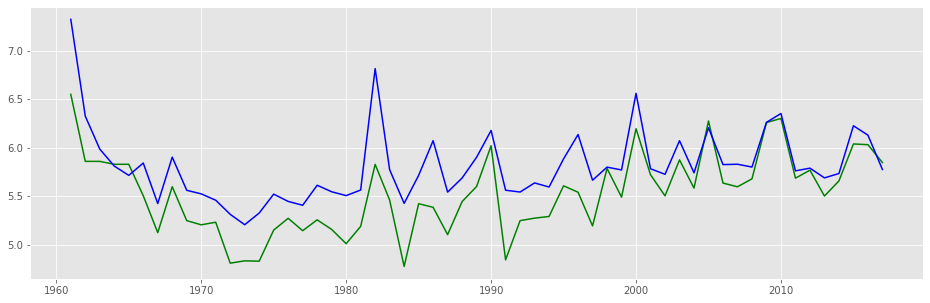

In [41]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from sklearn.linear_model import LinearRegression


#prices['Anomaly'] = np.nan
#for year in range(1961, 2018):
#    linreg = LinearRegression()
#    linreg.fit(np.array(range(year-10, year)).reshape(-1,1), prices.loc[year-10 : year-1, 'Price'])
#    prices.loc[year, 'Anomaly'] = prices.loc[year, 'Price'] - linreg.predict(np.array(year).reshape(-1,1))
#
price_st_em = np.log(prices_st_em['Price']).loc[1961:]
price_medoc = np.log(prices_medoc['Price']).loc[1961:]


######### Yeo Johnson transofrmation

#price = np.log(price)

#pt = PowerTransformer()
#price = pt.fit_transform(np.log(prices['Price'].loc[1961:]).values.reshape(-1,1))/2

#print(df.agg(['skew', 'kurtosis']).T)

plt.plot(price_st_em, color='green')
plt.plot(price_medoc, color='blue')

df_st_em = df_st_em.loc[1961:]
df_st_em['Log price'] = price_st_em
df_st_em['Log price centered'] = price_st_em - np.mean(price_st_em)

print('\nSt Emilion:')
print(df_st_em[['Log price']].agg(['skew', 'kurtosis']).T)

df_medoc = df_medoc.loc[1961:]
df_medoc['Log price'] = price_medoc
df_medoc['Log price centered'] = price_medoc - np.mean(price_medoc)

print('\nMedoc :')
print(df_medoc[['Log price']].agg(['skew', 'kurtosis']).T)

df_st_em.to_excel('data/generated_features_st_em.xlsx')
df_medoc.to_excel('data/generated_features_medoc.xlsx')

Saint-Emilion:


Log price                        1.000000
Tm: vendanges                    0.781547
ETP: vendanges                   0.743237
Tn: vendanges                    0.717357
SoilHum: vendanges               0.680465
Tx: vendanges                    0.658405
Stress: vendanges                0.652163
Growing Season Tm                0.644944
P: veraison - end vendanges      0.601293
Sun: vendanges                   0.596358
ETP: floraison - veraison        0.582148
P: vendanges                     0.574036
Sun: veraison - vendanges        0.525968
ETP: veraison - end vendanges    0.488802
DTR: vendanges                   0.484213
P: veraison - vendanges          0.464734
GDD10                            0.457743
Stress: veraison - vendanges     0.427140
Evap: vendanges                  0.425708
Tn: floraison - veraison         0.411595
Name: Log price, dtype: float64


Medoc:


Log price                        1.000000
Tx: vendanges                    0.837548
DTR: vendanges                   0.824472
Sun: vendanges                   0.768580
Tm: vendanges                    0.768474
ETP: vendanges                   0.767735
SoilHum: vendanges               0.744126
Stress: vendanges                0.701470
DTR: fleur                       0.686365
DTR: floraison - veraison        0.684137
Wind: floraison - veraison       0.674385
P: veraison - end vendanges      0.658815
P: vendanges                     0.637803
Stress                           0.613900
SoilHum: veraison - vendanges    0.600754
Evap: veraison - vendanges       0.541054
Evap                             0.537597
Tx: floraison - veraison         0.520173
Tn: vendanges                    0.518991
Evap: vendanges                  0.517133
Name: Log price, dtype: float64


Combined:


Log price                        1.000000
Tm: vendanges                    0.781547
ETP: vendanges                   0.743237
Tn: vendanges                    0.717357
SoilHum: vendanges               0.680465
Tx: vendanges                    0.658405
Stress: vendanges                0.652163
Growing Season Tm                0.644944
P: veraison - end vendanges      0.601293
Sun: vendanges                   0.596358
ETP: floraison - veraison        0.582148
P: vendanges                     0.574036
Sun: veraison - vendanges        0.525968
ETP: veraison - end vendanges    0.488802
DTR: vendanges                   0.484213
P: veraison - vendanges          0.464734
GDD10                            0.457743
Stress: veraison - vendanges     0.427140
Evap: vendanges                  0.425708
Tn: floraison - veraison         0.411595
Name: Log price, dtype: float64

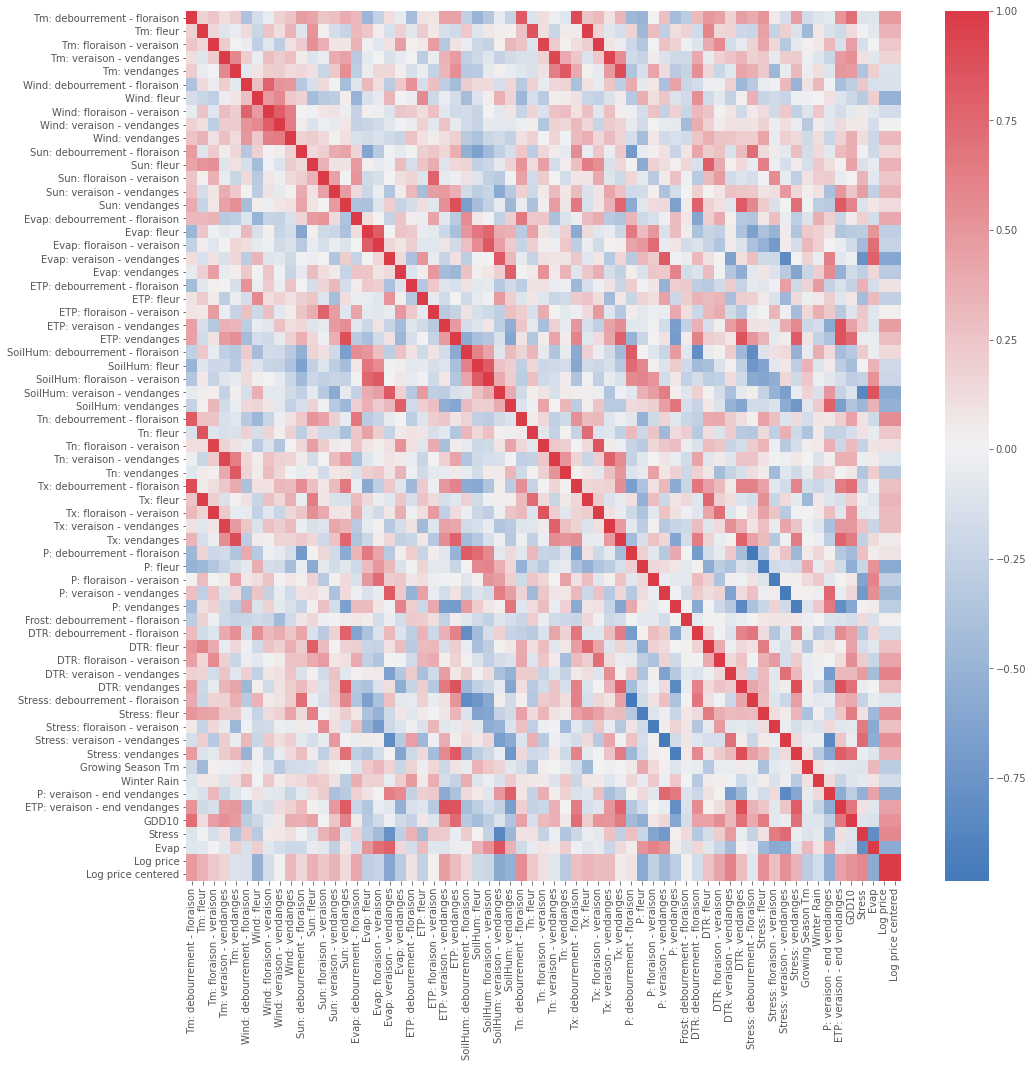

In [48]:
#print(df.loc[1983:1993, :].corr()['Log price'].abs().nlargest(30))
#print(df.loc[1994:2004, :].corr()['Log price'].abs().nlargest(20))
print('Saint-Emilion:')
display(df_st_em.loc[1984:1993, :].drop('Log price centered', axis=1).corr()['Log price'].abs().nlargest(20))
print('\nMedoc:')
display(df_medoc.loc[1984:1993, :].drop('Log price centered', axis=1).corr()['Log price'].abs().nlargest(20))
print('\nCombined:')
display(pd.concat((df_st_em.loc[1984:1993, :], df_st_em.loc[1984:1993, :]), axis=0).drop('Log price centered', axis=1).corr()['Log price'].abs().nlargest(20))

#display(df.loc[2005:, :].corr()['Log price'].abs().nlargest(20))

plt.figure(figsize=(16,16))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(pd.concat((df_st_em.loc[1994:, :], df_st_em.loc[1994:, :]), axis=0).corr(), cmap=cmap)
plt.show()

### Show correlations and pvals

#### GOOD_FEATURES = ['Stress',  'DTR: veraison - vendanges']: Spearman out-sample of 0.76, BEST TO DATE

In [45]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, Lasso, LinearRegression

df = df_st_em

GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur']


#X['Sq Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2
df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES].reset_index(drop=True)
y = df[['Log price']]
FIRST = 1961
LAST = 2018
WIDTH = 20

def model_tester(X, y, fixed_1994):
    coefficients = pd.DataFrame(0, index=range(FIRST,LAST-WIDTH-1), columns = ['const']+X.columns.to_list())
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST+WIDTH+1,LAST), columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in coefficients.index:
        oldest_vintage = year
        newest_vintage = year + WIDTH

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        #X_train = sm.add_constant(X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:])
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        #mod = sm.OLS(y_train.values.reshape(-1,1), X_train)
        #res = mod.fit()
        #coefs = pd.Series(res.params)
        #mod = Lasso(alpha=0.005)
        mod = LinearRegression()
        mod.fit(X_train, y_train.values)
        coefs = mod.coef_
        coefficients.loc[year, X_train.columns] = coefs
        coefficients.loc[year, 'const'] = mod.intercept_
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]
        #ones = pd.DataFrame(np.ones(1), index=[newest_vintage-FIRST+1], columns=['const'])
        #X_test = pd.concat((ones, X_test), axis=1)
        
        if fixed_1994:
            if year==1994-WIDTH-1:
                mod_base = mod
                
            if year >=1994-WIDTH-1:
                print(year+WIDTH+1, ': using 1993 model.')
                predictions.loc[newest_vintage+1] = mod_base.predict(X_test.values)[0]

    
            else:
                predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]

        else:
            predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return coefficients, r2_scores, spearman_scores, predictions

coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y, fixed_1994 = False)

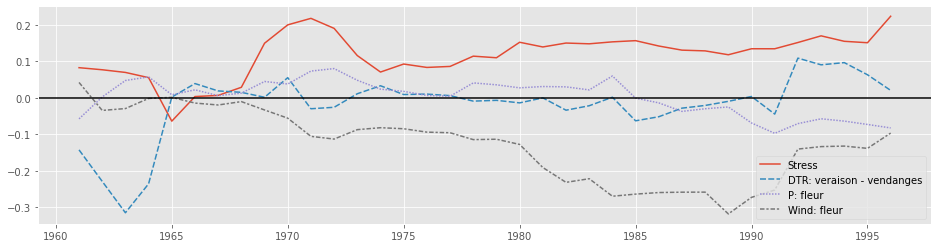

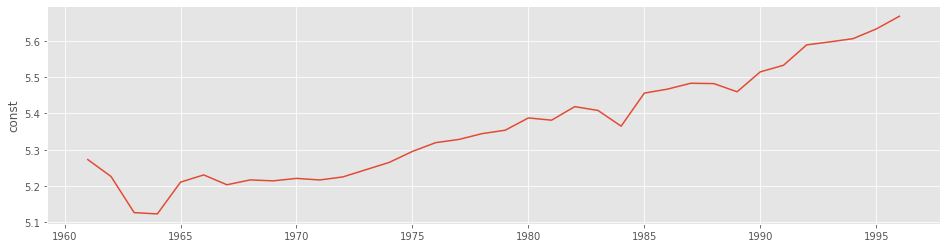

<Figure size 1152x288 with 0 Axes>

Average in-sample R2 score over the whole period:  -5.589271414379326
Average in-sample Spearman R over the whole period:  0.5514953760933574


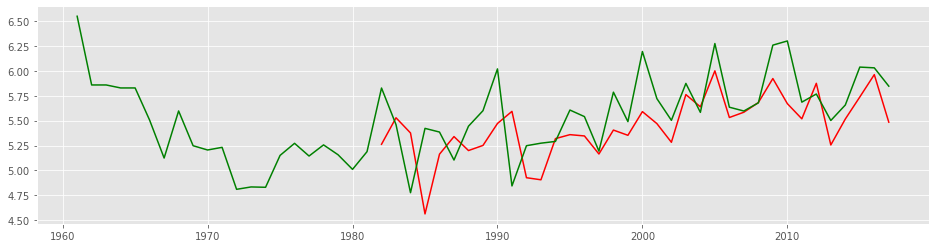

Average out-sample Spearman R over the target period:  0.7956521739130433
MAE over the target period:  0.20873303028431436
Average out-sample R2 over the target period:  0.1841726510577999


In [46]:
plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,1:6]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.iloc[:,0])
plt.show()

plt.figure(figsize=(16,4))
#sns.lineplot(data=coefficients.T.iloc[:,6:]).axhline(0., color='black')
plt.show()

print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))

plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')
plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()

def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))


#print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[FIRST+WIDTH+1:LAST], y.loc[FIRST+WIDTH+1:LAST])[0])
print('Average out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:LAST], y.loc[1994:LAST])[0])
print('MAE over the target period: ',np.mean(np.abs(predictions.loc[1994:].values- y.loc[1994:].values)))

print('Average out-sample R2 over the target period: ',r_squared(y.loc[1994:LAST].values, predictions.loc[1994:LAST].values))

In [37]:
residual = df.loc[FIRST+WIDTH+1:LAST, 'Log price'] - predictions.loc[FIRST+WIDTH+1:LAST, 'Log Price']
sns.jointplot(x = df.loc[FIRST+WIDTH+1:LAST,'Winter Tx'], y = residual)
plt.show()

KeyError: 'Winter Tx'

# Tree

Spearman: 0.47999191332505026


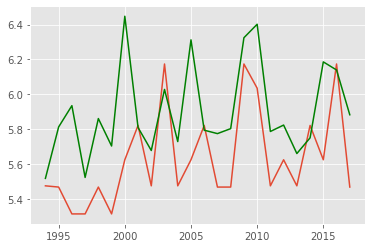

In [79]:
tree_features = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)
X = X[tree_features]

X_train, X_test = X.loc[1961:1993], X.loc[1994:2017]
y_train, y_test = y.loc[1961:1993], y.loc[1994:2017]

dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(X_train,y_train.values.ravel())

predictions = dtree.predict(X_test)
plt.plot(range(1994, 2018),predictions)
plt.plot(y_test, color='green')
print('Spearman:', spearmanr(predictions, y_test).correlation)

from sklearn import tree

#tree.plot_tree(dtree)

In [80]:
FIRST, LAST = 1961, 2017
window_width = 32

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1)[GOOD_FEATURES]
y = df[['Log price']]

def model_tester(X, y):
    r2_scores = []
    predictions = pd.DataFrame(index=range(FIRST + window_width +1,LAST +1), columns=['Log price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    
    for year in range(FIRST, LAST - (window_width+1)):
        oldest_vintage = year
        newest_vintage = year + window_width

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        X_train = X.loc[oldest_vintage-FIRST:newest_vintage-FIRST,:]
        
        mod = DecisionTreeRegressor(max_depth=3)
        mod.fit(X_train, y_train.values.ravel())
        
        r2_scores.append(r2_score(mod.predict(X_train),y_train))
        spearman_scores.append(spearmanr(mod.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-FIRST+1:newest_vintage-FIRST+1,:]        
        predictions.loc[newest_vintage+1] = mod.predict(X_test.values)[0]
    
    return r2_scores, spearman_scores, predictions

r2_scores, spearman_scores, predictions = model_tester(X, y)

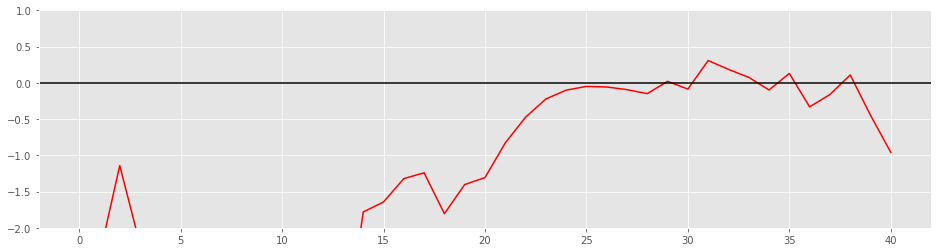

Average in-sample R2 score over the whole period:  -1.995630715015538


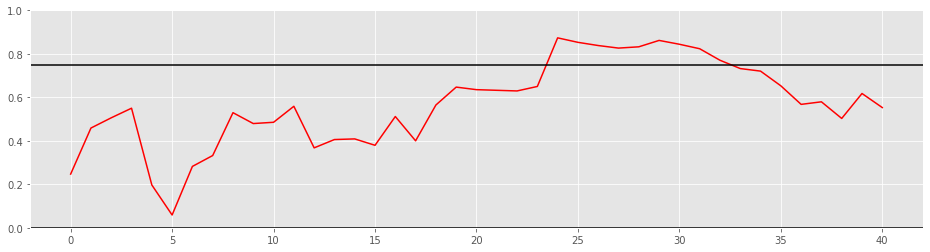

Average in-sample Spearman R over the whole period:  0.5699426111908178


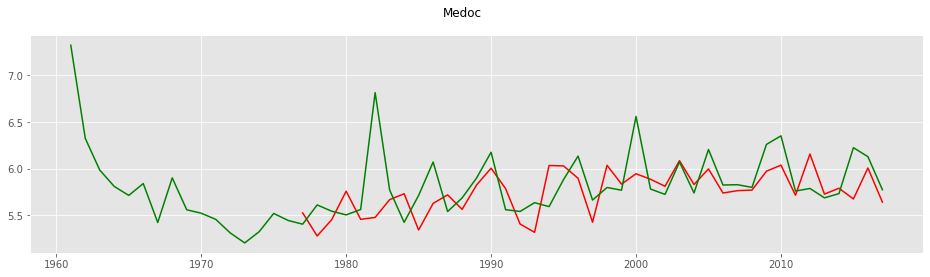

R2 over target period:  -0.01849995775202329
Out-sample Spearman R over the target period:  0.3409090909090909
Out-sample Spearman R over the target period:  0.3409090909090909


In [22]:
plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.suptitle(location)
plt.show()
print('R2 over target period: ', r2_score(y.loc[1994:2016], predictions.loc[1994:2016]))
print('Out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])
print('Out-sample Spearman R over the target period: ',spearmanr(predictions.loc[1994:2016], y.loc[1994:2016])[0])

# Appendix: PCA

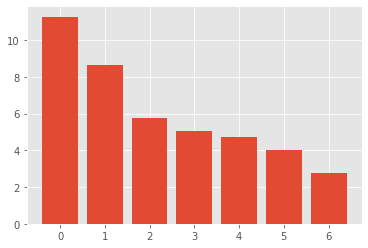

,0,1,2,3,4,5,6
1980,-4.354726,1.794528,0.970380,0.180457,1.694633,-0.256372,-1.641731
1981,0.832289,-2.561261,-1.263189,1.072136,0.367313,-0.680976,-1.267017
1982,2.985240,-0.121465,-2.080035,-0.772342,-1.123292,3.158297,2.591032
1983,1.130416,2.353051,2.173226,-0.231008,-3.864273,-0.755364,-1.200368
1984,-1.813309,-1.169158,-1.870055,-2.802077,1.346254,-1.121126,-0.302894


In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

X = df.drop('Log price', axis=1).loc[1961:1994]

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1980:,:]


pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)
display(X2.head())

In [83]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,2]
    n = coeff.shape[0]
    #plt.scatter(xs ,ys) #without scaling
    for i in range(len(labels)):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, labels[i], color = 'g', ha = 'center', va = 'center')

            
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')

coef = pca.components_

ax.scatter(coef[0,:] , coef[1, :] , coef[2, :])

for i in range(len(X.columns)):
    ax.text(coef[0,i]+np.mean(coef[0,:])/1000,coef[1,i]+np.mean(coef[1,:])/1000 ,coef[2,i]+np.mean(coef[2,:])/1000, list(X.columns)[i], zdir=None)

# 